In [1]:
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import requests
from datetime import datetime as dt
# https://github.com/RomelTorres/alpha_vantage
from alpha_vantage.timeseries import TimeSeries
from alpha_vantage.techindicators import TechIndicators 
from alpha_vantage.sectorperformance import SectorPerformances

In [2]:
API_URL = 'https://www.alphavantage.co/query?'
API_KEY = 'TMANNBF5NO707ZEI'

In [3]:
# Output formats: json dictionaries (default), DataFrame, csv.
# csv does not support ForeignExchange, SectorPerformances, TechIndicators.
# indexing_type can also be integer (default: date)
ts = TimeSeries(key=API_KEY, output_format='pandas', indexing_type='date')
ti = TechIndicators(key=API_KEY, output_format='pandas')
sp = SectorPerformances(key=API_KEY, output_format='pandas')

# Data Collection

This is the primary method for retrieving data from the AlphaVantage API. Rather than worrying about all of the individual data collection methods, this method allows the user to just specify the key parameters, and the appropriate API method retrieves the data.

In [4]:
global port # dictionary
global port_rets # dictionary

port = {} # Stores all stock data
port_rets = {} # Stores all return data

# symbols: list of stock tickers as strings
# start_date, end_date: string of date 'YYYY-MM-DD'
# intra_int: intraday interval; '1min', '5min', '15min', '30min', 
#'60min' (default '15min')
# add: by default adds the searched asset to the portfolio.
def get_data(symbol, start_date= None, end_date= None, 
             int_type='daily_adjusted', intra_int='15min', add=True):

    if int_type is 'daily_adjusted':
        data, meta = ts.get_daily_adjusted(symbol, outputsize='full')
    elif int_type is 'daily':
        data, meta = ts.get_daily(symbol, outputsize='full')
    elif int_type is 'intraday':
        data, meta = ts.get_intraday(symbol, interval=intra_int, 
                                     outputsize='full')
    elif int_type is 'weekly':
        data, meta = ts.get_weekly(symbol)
    elif int_type is 'weekly_adjusted':
        data, meta = ts.get_weekly_adjusted(symbol)
    elif int_type is 'monthly':
        data, meta = ts.get_monthly(symbol)
    elif int_type is 'monthly_adjusted':
        ts.get_monthly_adjusted(symbol)   

    # Remove numbers from column labels.
    data.rename(columns=lambda col: col[3:], inplace=True)
    
    # Filter the DataFrame to contain only those specified by the start 
    # and end dates.
    if start_date and end_date:
        data = data.loc[start_date:end_date]
    elif start_date:
        data = data.loc[start_date:]
    else:
        data = data.loc[:end_date]
    
    # Add the stock data to a DataFrame and reindex to be DateTime indices.
    df_stock = pd.DataFrame(data)
    df_stock.index = pd.to_datetime(df_stock.index)
    
    # By default, add to the portfolio
    if add:
        port[symbol] = df_stock
    
    return pd.DataFrame(df_stock)

In [5]:
# portfolio: may refer to portfolio containing all stocks or an 
# individual stock
# symbol: specify ticker as string if calculating an individual 
# stock's returns not already in the portfolio
def calculate_returns(portfolio, symbol=None):
    
    # True if the portfolio is a dictionary containing multiple stocks.
    if type(portfolio) is type({1:2}):
        for symb, data in portfolio.items():

            # Get price close data.
            daily_close = data['close']
            
            # Calculate percent change for each period.
            daily_pct_change = daily_close.pct_change()
            daily_pct_change.fillna(0, inplace=True)

            # Calculate log returns for each period.
            daily_log_returns = np.log(daily_close.pct_change()+1)
            daily_log_returns.fillna(0, inplace=True)

            # Cumulative daily rate of return is useful to determine the 
            # value of an investment at regular intervals.
            cum_daily_return = (1 + daily_pct_change).cumprod()
            port_rets[symb] = pd.DataFrame({'pct change': daily_pct_change, 
                                       'log returns':daily_log_returns, 
                                       'cumulative daily':cum_daily_return})
        return port_rets[symb]
    
    # True if only calculating for one stock.
    else:
        daily_close = portfolio['close']
        daily_pct_change = daily_close.pct_change()
        daily_pct_change.fillna(0, inplace=True)

        daily_log_returns = np.log(daily_close.pct_change()+1)
        daily_log_returns.fillna(0, inplace=True)
        
        # Cumulative daily rate of return is useful to determine 
        # the value of an investment at regular intervals.
        cum_daily_return = (daily_pct_change).sum()
        port_rets[symbol] = pd.DataFrame({'pct change': daily_pct_change, 
                                       'log returns':daily_log_returns, 
                                       'cumulative daily':cum_daily_return})
        return port_rets[symbol]

# Construct the Portfolio and Timeframe

In [6]:
# Enter start date
start = '2018-04-03'

# Default set to today
end = dt.today().strftime('%Y-%m-%d')

epd = get_data('EPD', start, end)
hrtx = get_data('HRTX', start, end)
pags = get_data('PAGS', start, end)
qqq = get_data('QQQ', start, end)
comm = get_data('COMM', start, end)

In [7]:
spy = get_data('SPY', start, end)

In [8]:
calculate_returns(port);

# Plotting: Historical Price, Percent and Cumulative Returns

Let's take a look at how the stocks within our portfolio have performed over the past year. COMM has also been added to these plots for comparison.

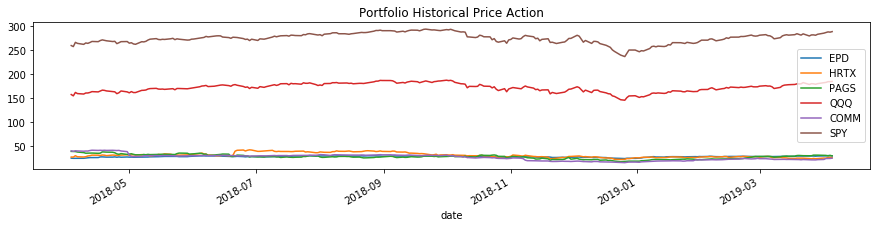

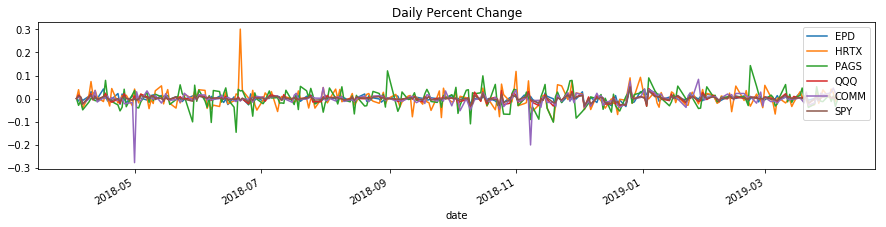

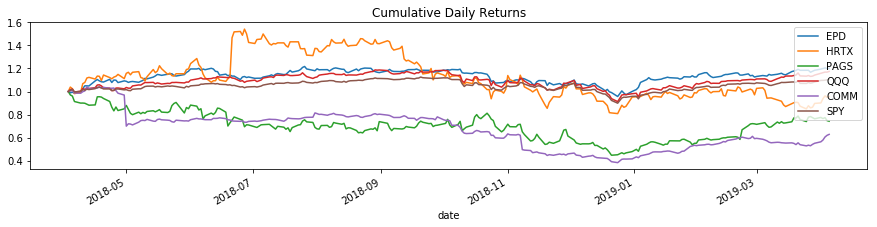

In [9]:
# Plot price action
for sym, data in port.items():
    data['open'].plot(figsize=(15,3), label=sym,legend=True)
plt.title('Portfolio Historical Price Action')
plt.show()

# Plot daily pct change
for sym, data in port_rets.items():
    data['pct change'].plot(figsize=(15,3), label=sym,legend=True)
plt.title('Daily Percent Change')
plt.show()

# Plot cumulative returns
for sym, data in port_rets.items():
    data['cumulative daily'].plot(figsize=(15,3), label=sym,legend=True)
    x = data['cumulative daily']
plt.title('Cumulative Daily Returns')
plt.show()

# Statistical Measurements

Now, let's look at some basic statistical observations. Plotting returns with a histogram allows us to see how the returns are distributed. Obviously, it's better for the returns to be skewed towards the right, but this is allows means that the returns are not normally distributed, which is an assumption required by some forms of regression analysis.

## Percent Change Distribution

In [10]:
# time_of_price={open, high, low, close, adjusted close, volume}
def get_var(ticker, param='adjusted close'):
    return np.var(port[ticker][param]), np.std(port[ticker][param])

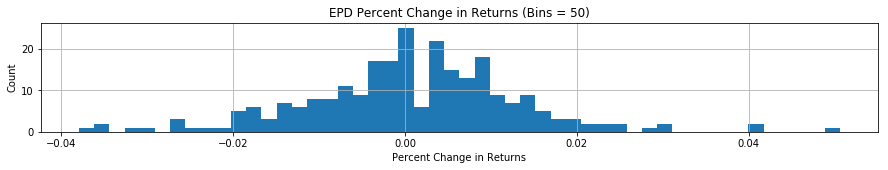

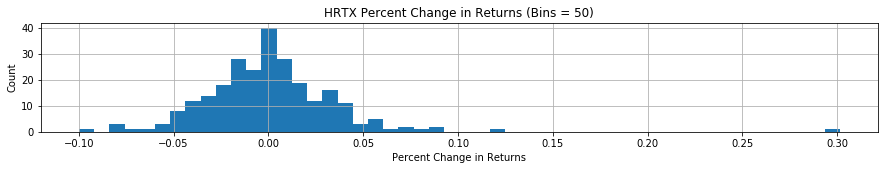

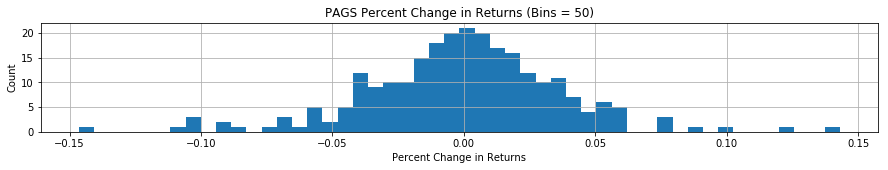

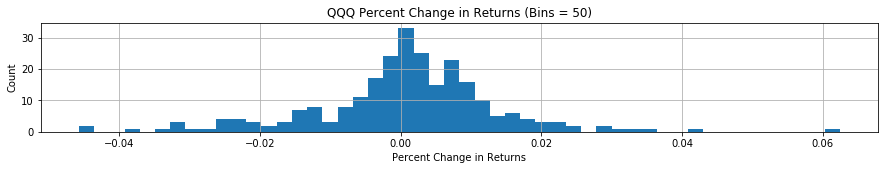

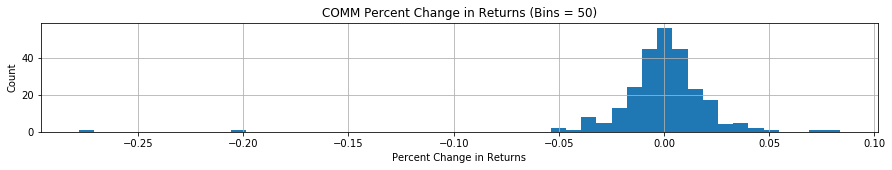

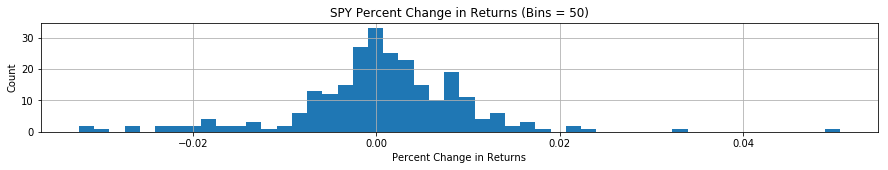

In [11]:
bins = 50
for sym, data in port_rets.items():
    port_rets[sym]['pct change'].hist(bins=bins, figsize=(15,2))
    plt.title(f'{sym} Percent Change in Returns (Bins = {bins})')
    plt.xlabel('Percent Change in Returns')
    plt.ylabel('Count')
    plt.show()

## Volatility

Let's take a look at how volatile our stocks are compared to the S&P500. The price action of the stock is also plotted to allow us to see if the volatility is a result of upward or downward price action.

In addition, below each plot the mean, standard deviation, and standard error of the mean. One way of interpreting the standard error is that it accounts for the randomness in measuring the mean. Thus, in experimentation, two measurements can be considered signficantly different if there means do not overlap when adding or subtracting off their standard errors.

Volatility can be measured by the rolling standard deviation of a stock's percent change. It is also important to contextualize the volatility of a stock with a benchmark. In this case, the benchmark has been chosen to be the S&P500.

In [35]:
# Plot the volatility of an asset in the portfolio.
# show_price: if True, also plots price data of the stock.
# show_benchmark: if True, also plots volatility of S&P 500.
def plot_port_vol(ticker, min_periods=15, show_price=False, 
                  show_bench=False):
    
    global price, bench_vol
    price= None
    bench_vol= None

    # Get the asset volatility and optionally the S&P volatility 
    # and price data of the asset.    
    vol = port_rets[ticker]['pct change'].rolling(
        min_periods).std()*np.sqrt(min_periods)
    if show_bench:
        start = str(port_rets[ticker].index[0])[:-9]
        end = str(port_rets[ticker].index[-1])[:-9]
        bench_data = get_data('SPY', start_date= start, end_date= end)
        bench_rets = calculate_returns(bench_data)
        bench_vol = bench_rets['pct change'].rolling(
            min_periods).std()*np.sqrt(min_periods)
    if show_price:
        price = port[ticker]['close']
    
    fig, ax1 = plt.subplots(figsize=(12,3))
    
    vol_color = 'tab:red'
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Percent')
    ax1.plot(vol, color=vol_color, label=ticker)
    ax1.legend(loc=1)
    
    if show_bench:
        bench_color='tab:orange'
        ax1.plot(bench_vol, color=bench_color, label='S&P')
        ax1.legend(loc=1)
    if show_price:
        ax2 = ax1.twinx() # second axes with same x-axis
        price_color = 'tab:blue'
        ax2.set_ylabel(f'{ticker} Price')
        ax2.plot(price, color=price_color, label=f'{ticker} price')
        ax2.tick_params(axis='y', labelcolor=price_color)
        ax2.legend(loc=2)
    vol.dropna()
    asset_mean = vol.mean()
    asset_std_dev = vol.std()
    asset_std_err = vol.sem()
    
    bench_mean = bench_vol.mean()
    bench_std_dev = bench_vol.std()
    bench_std_err = bench_vol.sem()
    
    fig.tight_layout()
    plt.title(f'{ticker} vs. S&P: Volatility ({min_periods}-Day)')
    plt.show()
        
    vol_stats = pd.DataFrame(index=['mean', 'std dev', 'std err'])
    vol_stats[ticker] = pd.Series(
        (asset_mean, asset_std_dev, asset_std_err), index=vol_stats.index)
    vol_stats['S&P 500'] = pd.Series(
        (bench_mean, bench_std_dev, bench_std_err), index=vol_stats.index)
    
    agree=False
    if asset_mean <= bench_mean and (
        asset_mean + asset_std_err >= bench_mean):
        agree = True
    elif asset_mean >= bench_mean and (
        asset_mean - asset_std_err <= bench_mean):
        agree=True
    
    print(vol_stats) 
    print(f'S&P and {ticker} agree within std error: {agree}')

Let's look at the stock that we're considering acquiring, COMM.

In [36]:
start = str(port_rets['COMM']['pct change'].index[0])[:-9]
end = str(port_rets['COMM']['pct change'].index[-1])[:-9]

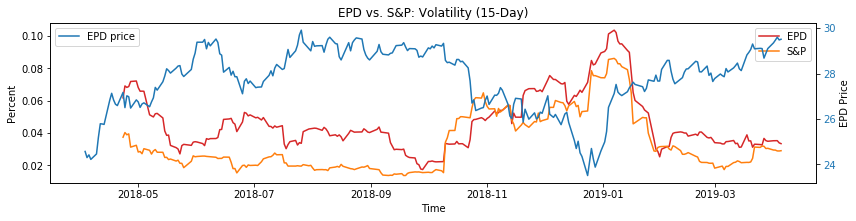

              EPD   S&P 500
mean     0.046023  0.033058
std dev  0.017414  0.017903
std err  0.001122  0.001153
S&P and EPD agree within std error: False


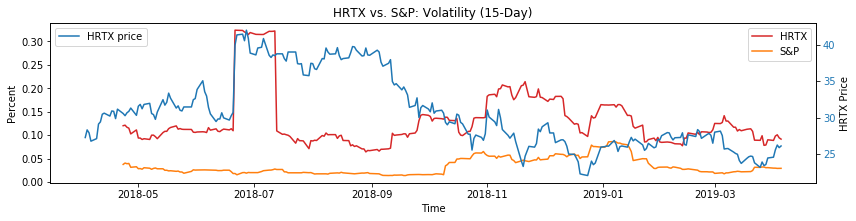

             HRTX   S&P 500
mean     0.130186  0.033058
std dev  0.058875  0.017903
std err  0.003792  0.001153
S&P and HRTX agree within std error: False


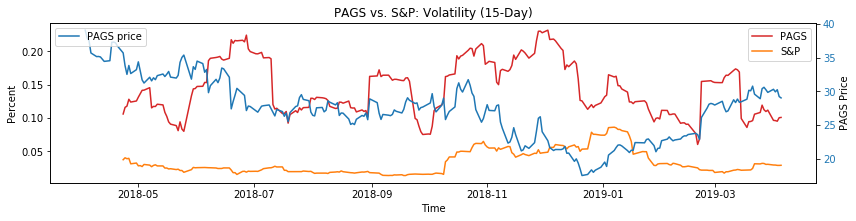

             PAGS   S&P 500
mean     0.143571  0.033058
std dev  0.040681  0.017903
std err  0.002621  0.001153
S&P and PAGS agree within std error: False


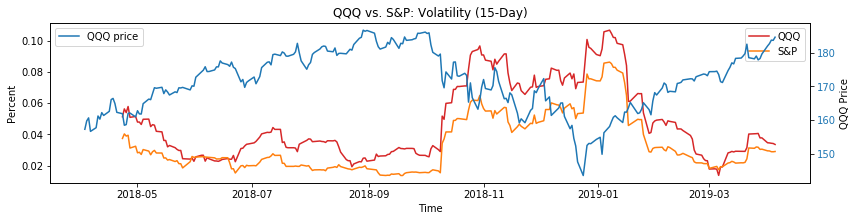

              QQQ   S&P 500
mean     0.047239  0.033058
std dev  0.023808  0.017903
std err  0.001534  0.001153
S&P and QQQ agree within std error: False


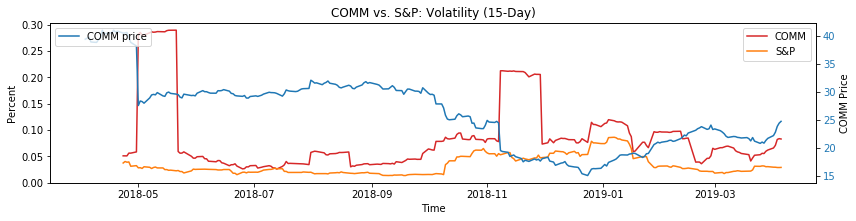

             COMM   S&P 500
mean     0.084913  0.033058
std dev  0.066826  0.017903
std err  0.004305  0.001153
S&P and COMM agree within std error: False


In [37]:
for sym, data in port.items():
    if sym is not 'SPY':
        plot_port_vol(sym, show_bench=True, show_price=True)
        plt.show()

## Linear Regression and Scatter Matrix (Correlation)

One simple of way of observing how assets behave is by comparing how their prices move with respect to each other. That is, have one stock's price be the x-coordinate and the other be the y-coordinate, and plot the resulting points. If you get a clear line, you know that the two stocks are highly correlated. I'm sure you're familiar with this form of analysis, linear regression. 

However, one should be cautious to assume that two stocks that are correlated are not necessarily causated. That is, one directly influences the price movement of the other. Below, you can see that QQQ and SPY are highly correlated, which is likely because the two are both finance indexes and contain some of the same assets.

Generally, it is ideal to have a with UNCORRELATED stocks as this can lead to greater stability in terms of returns; because no price movement is correlated with any others. In this way, linear regression can prevent having a portfolio with similarly behaving stocks, which can reduce risk exposure.

The scatter matrix below looks confusing, but it's simply a grid of correlation plots. Plots that look like a line (e.g. QQQ and SPY) are highly correlated. The R squared value (goodness-of-fit), p-value (used later for hypothesis testing), and the standard error of margin (not entirely sure what this is used for), are also listed in tabular form.

In [17]:
def plot_linreg(asset_1, asset_2, xlabel=None, ylabel=None, visible=True):
    params = stats.linregress(asset_1, asset_2)
    m = params.slope
    b = params.intercept
    x = np.linspace(np.min(asset_1), np.max(asset_1), 500)
    y = m*x + b
    
    if visible:
        plt.scatter(asset_1, asset_2)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.plot(x, y)
        plt.show()
    
    return ('%.3f'%(params.rvalue**2), 
            '%.3f'%(params.pvalue), 
            '%.3f'%(params.stderr))

,R squared,std err,p value
EPD/HRTX,0.214,0.206,0.000
EPD/PAGS,0.052,0.201,0.000
EPD/QQQ,0.764,0.197,0.000
EPD/COMM,0.065,0.283,0.000
EPD/SPY,0.710,0.265,0.000
HRTX/PAGS,0.067,0.054,0.000
HRTX/QQQ,0.293,0.092,0.000
HRTX/COMM,0.374,0.063,0.000
HRTX/SPY,0.246,0.116,0.000
PAGS/QQQ,0.063,0.120,0.000


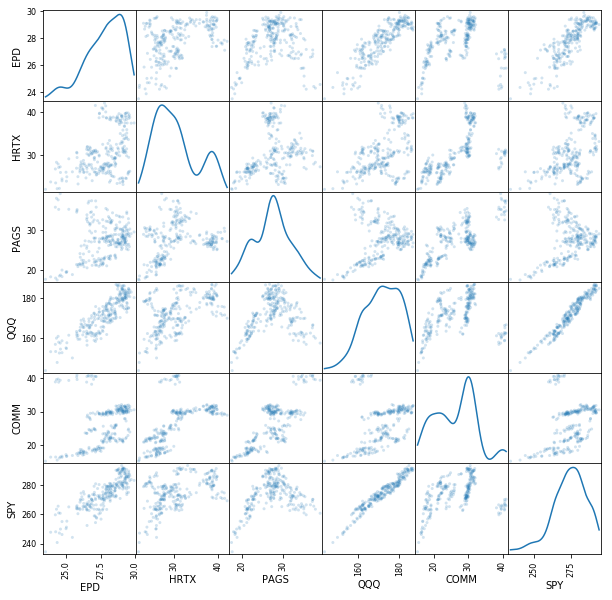

In [18]:
# Plot scatter matrix of portfolio.
close = pd.DataFrame()
for s, d in port.items():
    close[s] = port[s]['close']
pd.plotting.scatter_matrix(close, alpha=0.2,figsize=(10,10), 
                           diagonal='kde');

# Plot all linear regressions of the stocks within the portfolio.
hash_combos = []
sym_combos = []

regress_stats = pd.DataFrame(columns=['R squared', 'std err', 'p value'])

#rsq, pval, std

for sym, data in port.items():
    for s, d in port.items():       
        if sym is not s and (hash(sym+s) and hash(s+sym) not in hash_combos):
            rsq,pval,std = plot_linreg(port[sym]['close'], 
                                       port[s]['close'], 
                                       visible=False)
            h = hash(sym+s)
            hash_combos.append(h)
            values =pd.Series(
                [rsq, std, pval], 
                index=regress_stats.columns).rename(f'{sym}/{s}')
            regress_stats = regress_stats.append(values)
            
regress_stats

In [19]:
stock = 'COMM'

# Enter start date
start = '2018-04-05'

# Default set to today
end = dt.today().strftime('%Y-%m-%d')

macd, macd_meta = ti.get_macd(stock)
macd = pd.DataFrame(macd)
macd.index = pd.to_datetime(macd.index)

rsi, rsi_meta = ti.get_rsi(stock)
rsi = pd.DataFrame(rsi)
rsi.index = pd.to_datetime(rsi.index)

boll, boll_meta = ti.get_bbands(stock, time_period=60)
boll = pd.DataFrame(boll)
boll.index = pd.to_datetime(boll.index)

ad, ad_meta = ti.get_ad(stock)
ad = pd.DataFrame(ad)
ad.index = pd.to_datetime(ad.index)

obv, obv_meta = ti.get_obv(stock)
obv = pd.DataFrame(obv)
obv.index = pd.to_datetime(obv.index)

# Technical Indicators

Let's finish our time with this notebook with a look at some technical indicators.

We'll start with a 1-year timeframe and the following technical indicators:
    
* MACD
* RSI
* Bollinger Bands
* Chaikin A/D line 
* On-balance volume

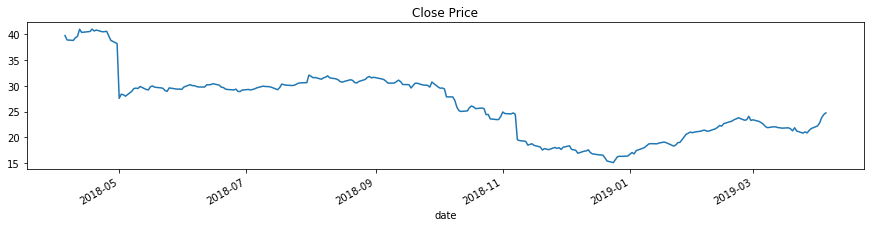

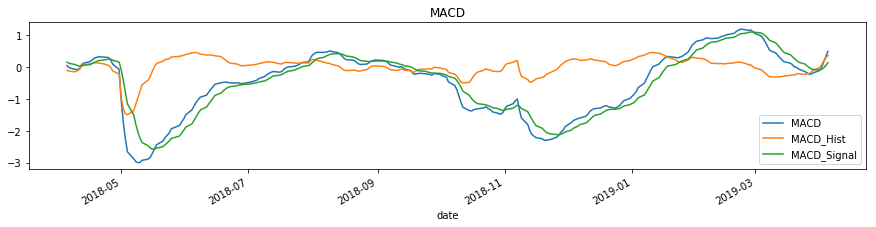

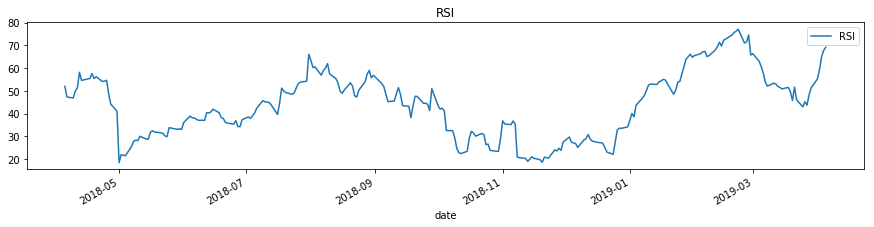

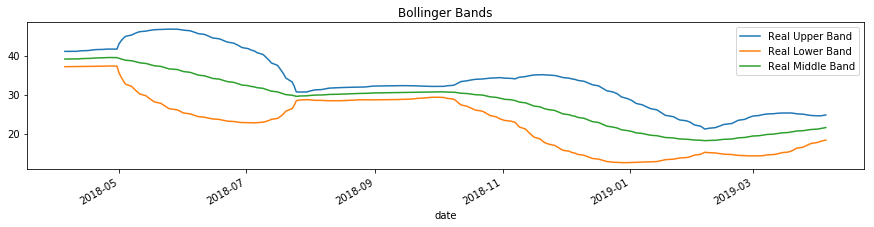

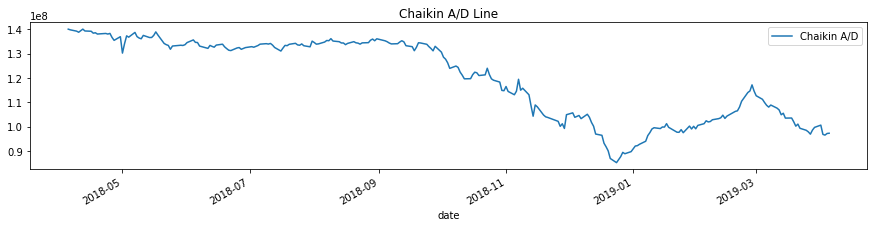

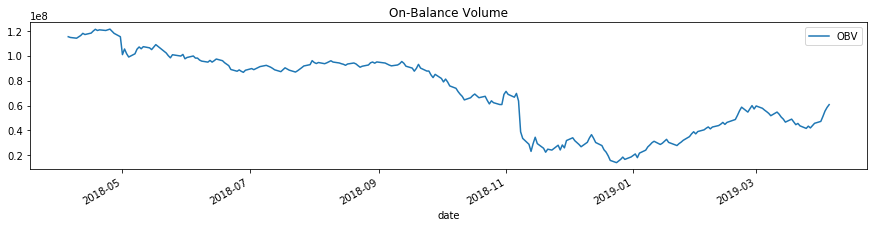

In [20]:
size = (15,3)
port['COMM']['close'][start:end].plot(title='Close Price', figsize=size)
macd[start:end].plot(title= 'MACD', figsize=size);
rsi[start:end].plot(title='RSI', figsize=size);
boll[start:end].plot(title='Bollinger Bands', figsize=size);
ad[start:end].plot(title='Chaikin A/D Line', figsize=size);
obv[start:end].plot(title='On-Balance Volume', figsize=size);

...and now for a 1-month lookback period...

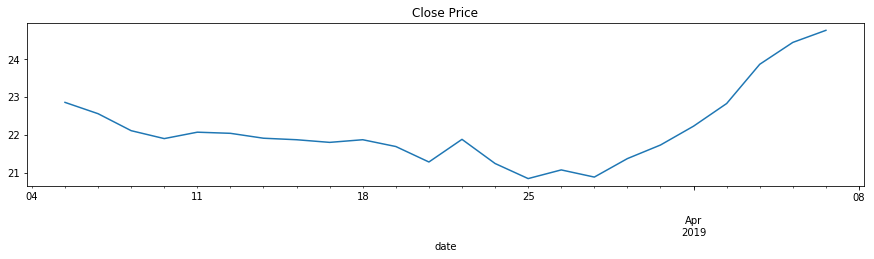

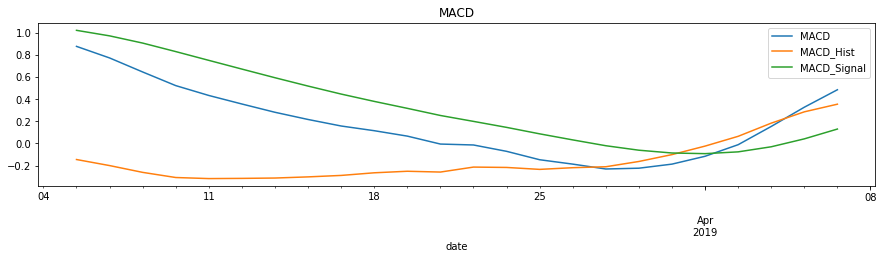

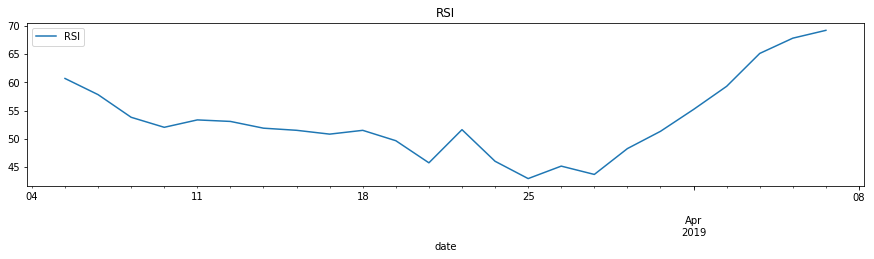

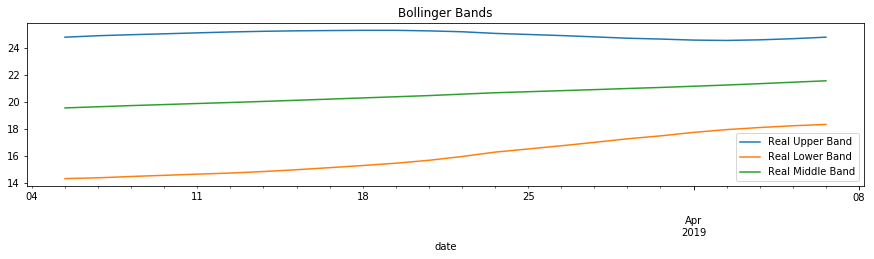

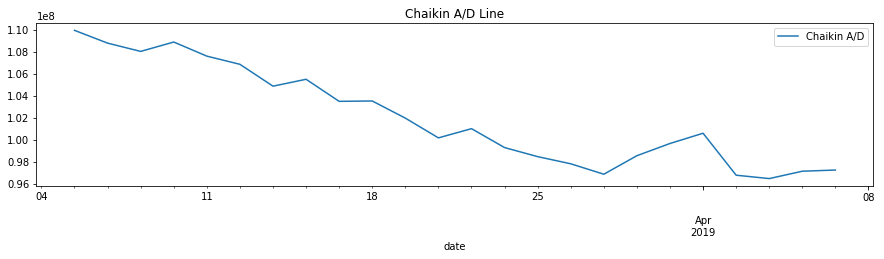

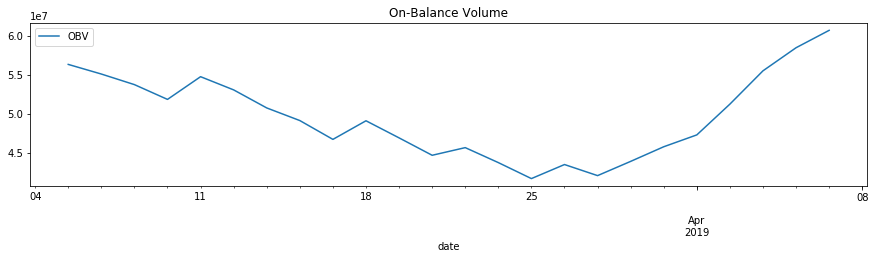

In [21]:
start = '2019-03-05'

size = (15,3)
port['COMM']['close'][start:end].plot(title='Close Price', figsize=size)
macd[start:end].plot(title= 'MACD', figsize=size);
rsi[start:end].plot(title='RSI', figsize=size);
boll[start:end].plot(title='Bollinger Bands', figsize=size);
ad[start:end].plot(title='Chaikin A/D Line', figsize=size);
obv[start:end].plot(title='On-Balance Volume', figsize=size);

## Remarks

In looking at the results from the 1-month view:

* The recent uptick in price as resulted in a reversal of the MACD, with the the historical crossing over the the signal, and going postive. Thus, there is some demonstrated positive momentum on this front.

* RSI has followed suit, but could indicate some signs of being overbought. Considering the acute price increase, COMM is likely to decline a bit before increasing again.

* The Bollinger Bands don't say much beyond the fact that the price is within the bonds of 2 standard deviations, so not much to say here.

* The accumulation/distribution line is a bit alarming. Considering that the price has increased, but A/D indicates selling-pressure is a sign of caution. This is another sign that we should wait a day or so to see if the price does not decline.

* The OBV shoes a more positive outlook. However, unlike the A/D indicator, the OBV does not scale with price change. Thus, the fact that the A/D line has declined and remains flat, despite significant price increase, should definitely be a potential warning sign of imminent correction.